In [1]:
# -*- coding: utf-8 -*-
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset.
# implemented Advanced Ensamble model (LightGBM) for classification.

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder


/tmp/ipykernel_2534252/2094684442.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-05 17:20:18.029190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 17:20:18.194585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 17:

In [2]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')
# tf.keras.backend.clear_session()

In [3]:
# Set the desired number of records for 'Normal' and 'Denial of Service' labels
desired_records_normal = 500000  # Change this to your desired number for 'Normal'
desired_records_dos = 3000000  # Change this to your desired number for 'Denial of Service'

# Filter data for 'Normal' and 'Denial of Service'
subset_df_normal = df[df['ALERT'] == 'Normal']
subset_df_dos = df[df['ALERT'] == 'Denial of Service']

# Sample the desired number of records from each class
subset_df_normal_sampled = subset_df_normal.sample(n=desired_records_normal, random_state=42)
subset_df_dos_sampled = subset_df_dos.sample(n=desired_records_dos, random_state=42)

# Combine the subsets with the rest of the data
final_subset = pd.concat([subset_df_normal_sampled, subset_df_dos_sampled, df[df['ALERT'] != 'Normal'][df['ALERT'] != 'Denial of Service']])

# Optional: Shuffle the final subset
final_subset = final_subset.sample(frac=1, random_state=42)


/tmp/ipykernel_2534252/364247859.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_subset = pd.concat([subset_df_normal_sampled, subset_df_dos_sampled, df[df['ALERT'] != 'Normal'][df['ALERT'] != 'Denial of Service']])


In [4]:
dropped_df = ['ALERT']
X = df.drop(dropped_df, axis=1)
y = df['ALERT']

# Label encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(df['ALERT'].value_counts())

ALERT
Normal               15049330
Denial of Service     5138973
Port Scanning         4170194
Malware                   571
Name: count, dtype: int64


In [5]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize MirroredStrategy for GPU acceleration
# strategy = tf.distribute.MirroredStrategy()

# # Train the models
# with strategy.scope():
  
    # Light GBM Light GBM beats all the other algorithms when the dataset is extremely large.
train_data = lgb.Dataset(X_train, label=y_train)
    # define parameters
    # params = {'learning_rate':0.001}
params = {
        'learning_rate': 0.001,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
}


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-05 17:21:47.161693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1047 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-03-05 17:21:47.162499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1046 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6


In [6]:
# lgb_model= lgb.train(params, train_data, 100)
lgb_model = lgb.train(params, train_data, num_boost_round=200)

# Make predictions on the test set
y_pred = lgb_model.predict(X_test)

# Threshold the predicted probabilities at 0.5 to obtain binary predictions
y_pred_encoded = [1 if prob >= 0.5 else 0 for prob in y_pred]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.571505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4759
[LightGBM] [Info] Number of data points in the train set: 19487254, number of used features: 27
[LightGBM] [Info] Start training from score 1.749238


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 2.339990812457126e-05


In [8]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test)

In [9]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

Denial of Service       0.00      0.00      0.00   1027795
          Malware       0.00      1.00      0.00       114
           Normal       0.00      0.00      0.00   3009866
    Port Scanning       0.00      0.00      0.00    834039

         accuracy                           0.00   4871814
        macro avg       0.00      0.25      0.00   4871814
     weighted avg       0.00      0.00      0.00   4871814



/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


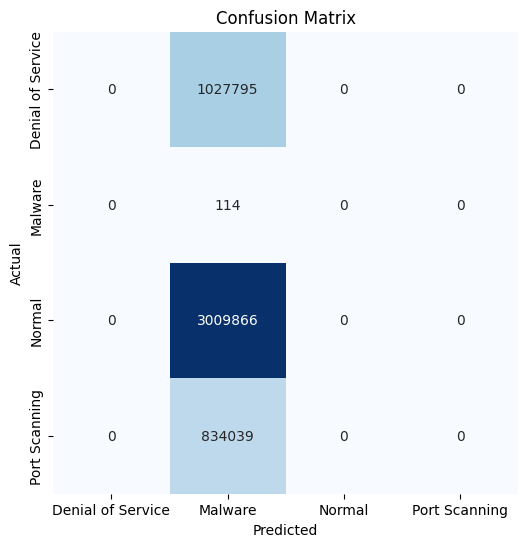

In [10]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()